# Importing libraries and reading data

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing


df_train_identity = pd.read_csv('train_identity.csv')
df_train_transaction = pd.read_csv('train_transaction.csv')


df_train = pd.merge(df_train_transaction, df_train_identity, on='TransactionID', how='left')

# Plotting data

In [23]:
probe = df_train.head(10000)
probe

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.500,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.000,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.000,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.000,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.000,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
5,2987005,0,86510,49.000,W,5937,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2987006,0,86522,159.000,W,12308,360.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987007,0,86529,422.500,W,12695,490.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2987008,0,86535,15.000,H,2803,100.0,150.0,visa,226.0,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
9,2987009,0,86536,117.000,W,17399,111.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


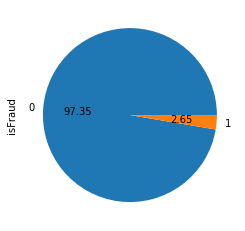

In [24]:
probe.isFraud.value_counts().plot(kind='pie',autopct='%.2f')

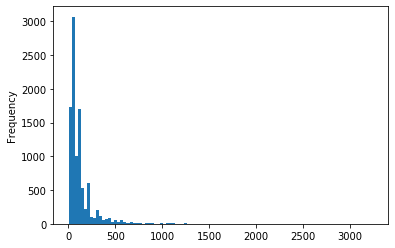

In [26]:
probe.TransactionAmt.plot(kind='hist',bins=100)

# Dropping nan columns and creating X and y

In [27]:
df_na_rate = pd.DataFrame(df_train.isna().mean().sort_values(ascending=False), columns=['na_rate']).reset_index()
na_rate_columns = list(df_na_rate.loc[df_na_rate.na_rate > 0.4]['index'])

df_train = df_train.drop(columns=na_rate_columns)


y = df_train['isFraud']
X = df_train.drop(columns=['isFraud'])
print(X.shape)
print(y.shape)


(590540, 201)
(590540,)


# Filling NaN

In [28]:
X = X.loc[:, 'C1':]
X = X.drop(columns=['M6'])


X.fillna(-999, inplace=True)

# Training model and showing confusion matrix

In [30]:
model = LogisticRegression()

# Define the splitter for splitting the data in a train set and a test set
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)

# Loop through the splits (only one)
for train_indices, test_indices in splitter.split(X, y):
    # Select the train and test data
    X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
    X_test, y_test = X.iloc[test_indices], y.iloc[test_indices]
    
    # Fit and predict!
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # And finally: show the results
    print(classification_report(y_test, y_pred))

C:\Users\PC\.conda\envs\tf_gpu\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PC\.conda\envs\tf_gpu\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.97      1.00      0.98    284939
           1       0.37      0.06      0.11     10331

    accuracy                           0.96    295270
   macro avg       0.67      0.53      0.54    295270
weighted avg       0.95      0.96      0.95    295270



In [31]:
confusion_matrix(y_test, y_pred)

array([[283862,   1077],
       [  9689,    642]], dtype=int64)

We have a lot of false negatives (9689)

# Training model with balanced weights and showing confusion matrix

In [32]:
model = LogisticRegression(class_weight ='balanced')

# Define the splitter for splitting the data in a train set and a test set
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)

# Loop through the splits (only one)
for train_indices, test_indices in splitter.split(X, y):
    # Select the train and test data
    X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
    X_test, y_test = X.iloc[test_indices], y.iloc[test_indices]
    
    # Fit and predict!
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # And finally: show the results
    print(classification_report(y_test, y_pred))

C:\Users\PC\.conda\envs\tf_gpu\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PC\.conda\envs\tf_gpu\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.99      0.71      0.83    284939
           1       0.08      0.72      0.15     10331

    accuracy                           0.71    295270
   macro avg       0.53      0.72      0.49    295270
weighted avg       0.95      0.71      0.80    295270



In [33]:
confusion_matrix(y_test, y_pred)

array([[203125,  81814],
       [  2854,   7477]], dtype=int64)

Now we have more false positives, but the recall has increased to 72%